## Predizione di Rischio di un Paziente relativo al Covid-19

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Antonelli Giacomo

In [67]:
# Librerie per l'analisi dei dati
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

# Librerie per la modellazione dei dati e la valutazione dei modelli
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from numpy import argmax

# Modelli valutati
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Parte 1 - Descrizione del dataset e l'obiettivo del modello

Il [dataset scelto](https://www.kaggle.com/datasets/meirnizri/covid19-dataset?resource=download) contiene diverse informazioni riguardo la salute di numerosi pazienti che hanno contratto o meno il virus COVID-19. Il modello avrà lo scopo di definire se un paziente è più propenso a sopravvivere o meno, basandosi solamente sulle informazioni cliniche. 
Applicato al mondo reale questo modello verrebbe usato per capire preventivamente la gravità delle condizioni di un paziente, e quindi fornirgli le cure adeguate per tempo in modo da aumentare le sue possibilità di sopravvivenza.

Il dataset in sé contiene 1.048.576 righe (una per ogni paziente) e 21 caratteristiche elencate qui di seguito:
- sex: 1 per le femmine e 2 per i maschi.
- age: età del paziente.
- classification: risultati del test covid. I valori da 1 a 3 significano che il paziente è stato diagnosticato con covid in diversi gradi. 4 o superiore significa che il paziente non è portatore di covid o che il test è inconcludente.
- patient type: tipo di assistenza che il paziente ha ricevuto nell'unità. 1 per il ritorno a casa e 2 per l'ospedalizzazione.
- pneumonia: se il paziente ha già un'infiammazione degli alveoli o meno.
- pregnancy: se il paziente è incinta o meno.
- diabetes: se il paziente ha il diabete o meno.
- copd: indica se il paziente ha la broncopneumopatia cronica ostruttiva o meno.
- asthma: se il paziente ha l'asma o meno.
- inmsupr: se il paziente è immunosoppresso o meno.
- hypertension: se il paziente ha l'ipertensione o meno.
- cardiovascular: se il paziente ha malattie legate al cuore o ai vasi sanguigni.
- renal chronic: se il paziente ha una malattia renale cronica o meno.
- other disease: se il paziente ha altre malattie o meno.
- obesity: se il paziente è obeso o meno.
- tobacco: se il paziente è un consumatore di tabacco.
- usmr: indica se il paziente è stato trattato in unità mediche di primo, secondo o terzo livello.
- medical unit: tipo di istituzione del Sistema Sanitario Nazionale che ha fornito le cure.
- intubed: se il paziente è stato collegato al ventilatore.
- icu: indica se il paziente è stato ammesso in un'Unità di Terapia Intensiva.
- date died: se il paziente è deceduto, indica la data della morte, e 9999-99-99 altrimenti.

Non tutti i dati sono presenti all'interno del dataset (indicati dai valori tra 97 e 99), mentre i valori booleani sono rappresentati da 1=si e 2=no.

In [26]:
# Dopo aver scaricato il file, lo carichiamo in un DataFrame
data = pd.read_csv("Covid Data.csv")
initial_size = data.memory_usage(deep=True).sum()/1024**2

print(f"Forma dei dati: {data.shape}\n")

data.head()

Forma dei dati: (1048575, 21)



,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# Parte 2 - Analisi esplorativa
In questa parte andrò ad analizzare le varie feature e valori del dataset attraverso grafici e strumenti statistici per capirne la distribuzione ed eventuali relazioni o problematiche.

Questa è la tabella che descrive le varie features del dataset:

In [27]:
data.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,7.952288e+01,3.346831e+00,4.179410e+01,4.976558e+01,2.186404e+00,2.260569e+00,2.242626e+00,2.298132e+00,2.128989e+00,2.435143e+00,2.261810e+00,2.125176e+00,2.257180e+00,2.214333e+00,5.305653e+00,7.955397e+01
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,3.686889e+01,1.191288e+01,1.690739e+01,4.751073e+01,5.424242e+00,5.132258e+00,5.114089e+00,5.462843e+00,5.236397e+00,6.646676e+00,5.194850e+00,5.175445e+00,5.135354e+00,5.323097e+00,1.881165e+00,3.682307e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,4.000000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,5.300000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,9.700000e+01
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,9.900000e+01,9.900000e+01,1.210000e+02,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,7.000000e+00,9.900000e+01


Essendo molti i dati e di diverso tipo, la tabella sopra mostrata può risultare confusionaria e non dire molto, perciò mostrerò di seguito alcune delle relazioni tra le features che ritengo più interessanti per questo dataset:

Una prima statistica interessante riguarda il numero di valori assenti, in questo caso questi non vengono rappresentati da NaN, ma bensì da valori numerici con range [97, 98, 99].

In [28]:
# Come da specifiche i dati assenti non sono rappresentati da NaN ma da numeri tra 97 e 99
print(f"Numero di NaN: {data.isna().sum().sum()}\n")

# Vado quindi a contare quanti sono i record con valori tra 97 e 99 per ogni colonna
print("Numero di record con feature tra 97 e 99:")
print(data.isin([97, 98, 99]).sum())

Numero di NaN: 0

Numero di record con feature tra 97 e 99:
USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        345
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64


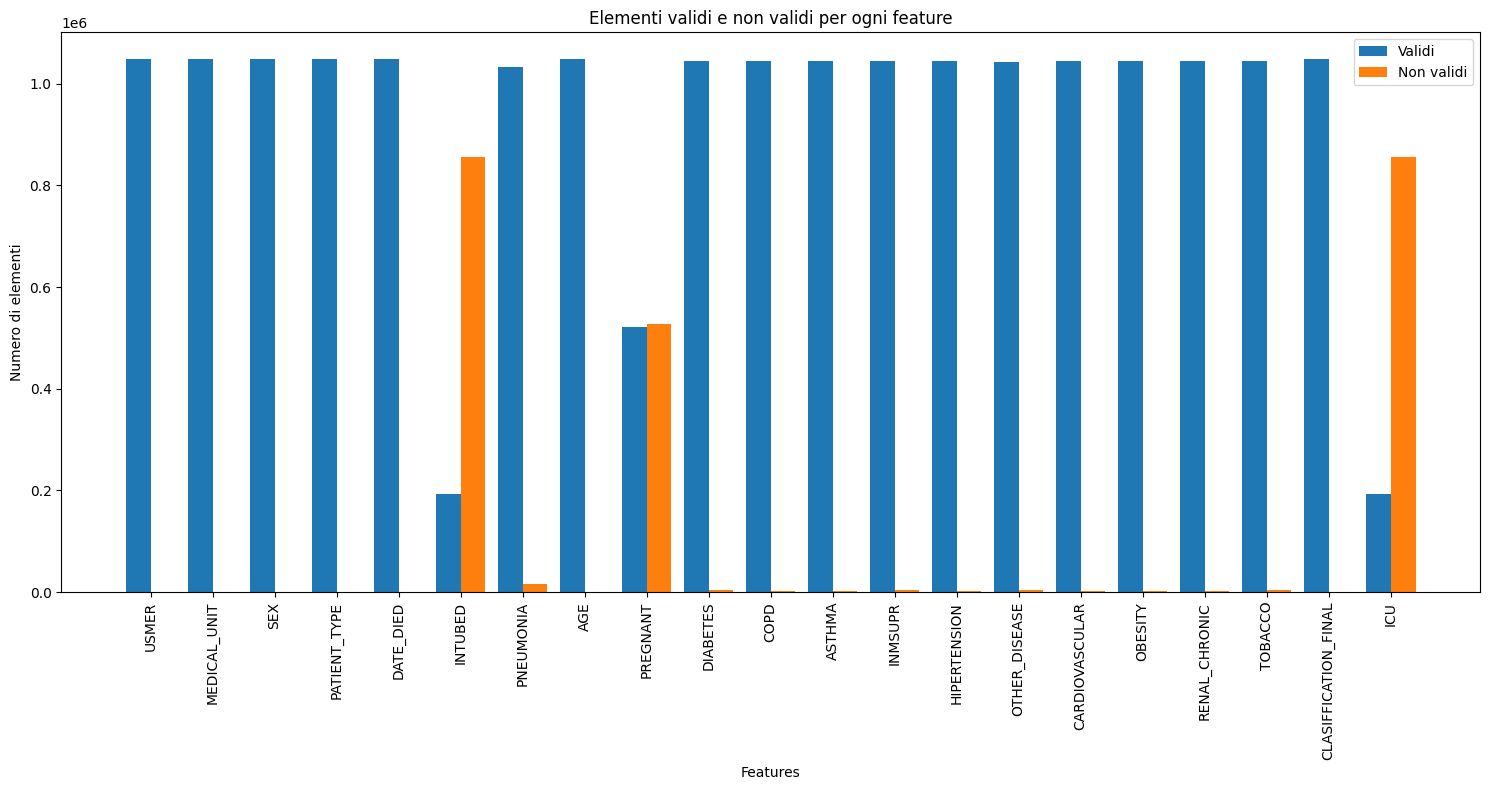

In [29]:
# Vado a mostrare questi dati graficamente, per avere una visione più chiara
invalid_values = {97, 98, 99}

valid_counts = []
invalid_counts = []

for col in data.columns:
    valid_count = data[col].apply(lambda x: x not in invalid_values).sum()
    invalid_count = data[col].apply(lambda x: x in invalid_values).sum()
    valid_counts.append(valid_count)
    invalid_counts.append(invalid_count)

x = np.arange(len(data.columns))
width = 0.4

fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width/2, valid_counts, width, label='Validi')
rects2 = ax.bar(x + width/2, invalid_counts, width, label='Non validi')

ax.set_xlabel('Features')
ax.set_ylabel('Numero di elementi')
ax.set_title('Elementi validi e non validi per ogni feature')
ax.set_xticks(x)
ax.set_xticklabels(data.columns, rotation=90)
ax.legend()

fig.tight_layout()

plt.show()

Dal seguente grafico si nota come tre feature in particolare (INTUBED, PREGNANT e ICU) abbiano un gran numero di dati assenti, che verranno gestiti nella sezione successiva.

Un'altra statistica interessante riguarda la distribuzione del numero di pazienti vivi e morti, come possiamo vedere nella tabella di seguito la maggior parte dei pazienti sono vivi, questo risulta particolarmente importante poiché un tale sbilanciamento dei dati potrebbe creare un effetto negativo nelle prestazioni del modello.

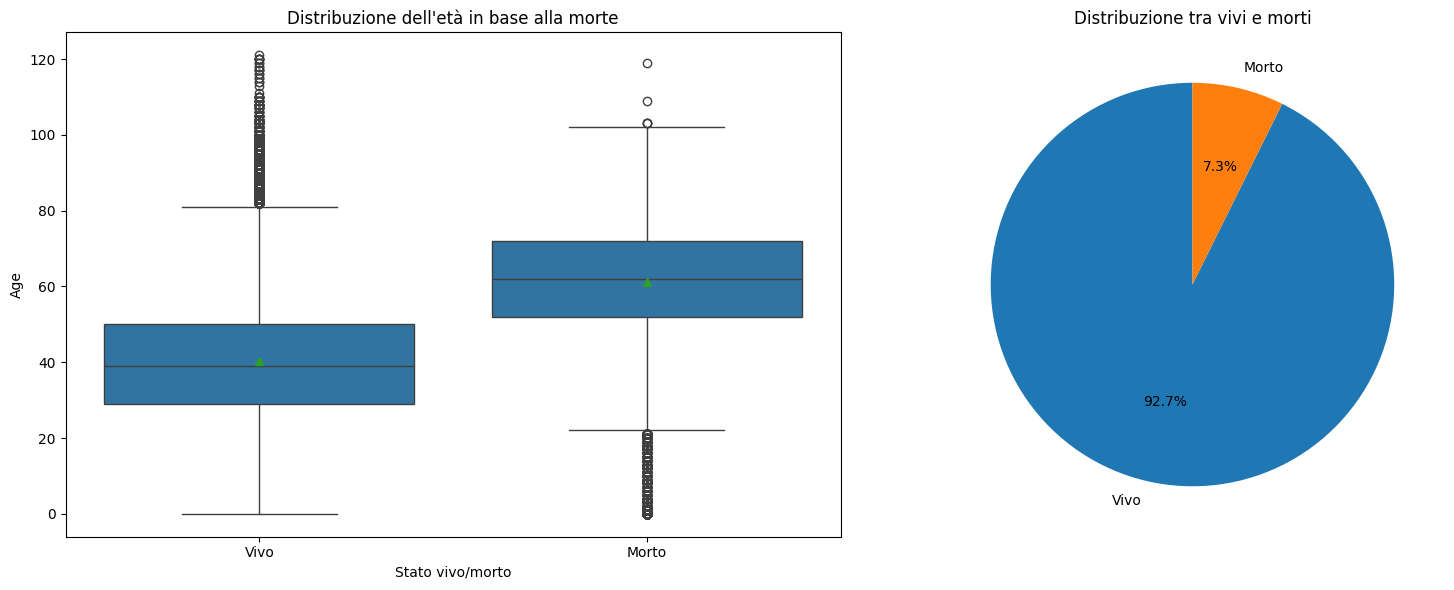

In [30]:
death_distr = data[["DATE_DIED", "AGE"]].copy()

# Converto la colonna DATE_DIED in una colonna binaria
death_distr.loc[death_distr.DATE_DIED != '9999-99-99', 'DATE_DIED'] = 'Morto'
death_distr.loc[death_distr.DATE_DIED == '9999-99-99', 'DATE_DIED'] = 'Vivo'

# Boxplot per l'età in base alla morte
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
death_distr = death_distr.sample(frac=1)
sns.boxplot(x='DATE_DIED', y='AGE', data=death_distr, showmeans=True, ax=axs[0])
axs[0].set_title('Distribuzione dell\'età in base alla morte')
axs[0].set_xlabel('Stato vivo/morto')
axs[0].set_ylabel('Age')

# Distribuzione dei dati tra vivi e morti
death_distr['DATE_DIED'].value_counts().plot(kind='pie', labels=['Vivo', 'Morto'], autopct='%1.1f%%', startangle=90, title='Distribuzione tra vivi e morti', ax=axs[1])
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

È interessante inoltre vedere la distribuzione del numero di pazienti vivi o morti rispetto alla loro età, come possiamo notare, il numero maggiore di pazienti morti lo troviamo intorno alla sessantina, numero comunque molto inferiore rispetto ai pazienti ancora vivi.

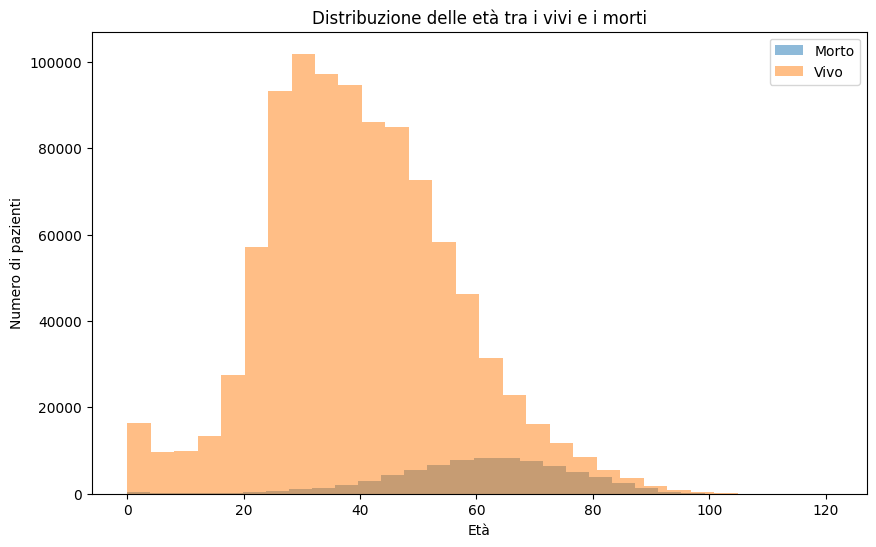

In [31]:
# Divido i pazienti vivi da quelli morti
died = data[data['DATE_DIED'] != '9999-99-99']
alive = data[data['DATE_DIED'] == '9999-99-99']

# Creo un istogramma basandomi sui dati dei due gruppi
plt.figure(figsize=(10,6))
plt.hist(died['AGE'], bins=30, alpha=0.5, label='Morto')
plt.hist(alive['AGE'], bins=30, alpha=0.5, label='Vivo')
plt.xlabel('Età')
plt.ylabel('Numero di pazienti')
plt.title('Distribuzione delle età tra i vivi e i morti')
plt.legend(loc='upper right')
plt.show()


Ad influire sulla sopravvivenza o meno della persona, oltre all'età c'è sicuramente la struttura in cui è stata ospitata, seguono quindi due grafici che mostrano il numero di persone vive e morte in ogni unità medica e la loro distribuzione per età:

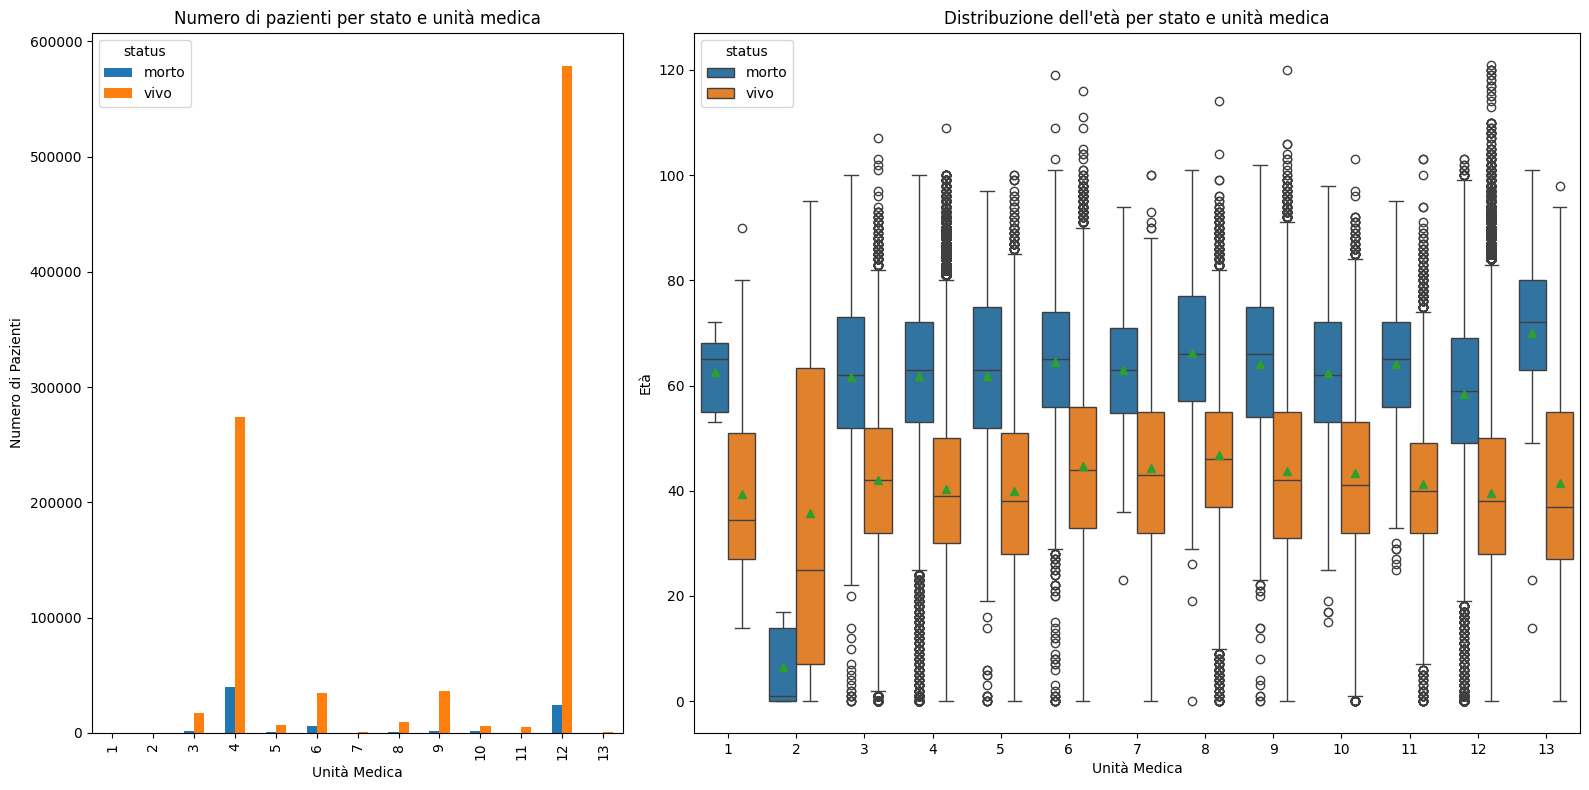

In [32]:
# Array che definisce lo stato di ogni paziente
data['status'] = data['DATE_DIED'].apply(lambda x: 'vivo' if x == '9999-99-99' else 'morto')

# Creo una griglia per i subplot (utilizzo GridSpec siccome i ratio dei due grafici sono diversi)
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 5])  

# Istogramma della sopravvivenza per ogni unità medica
ax0 = plt.subplot(gs[0])
data.groupby(['MEDICAL_UNIT', 'status']).size().unstack().plot(kind='bar', ax=ax0)
ax0.set_title('Numero di pazienti per stato e unità medica')
ax0.set_xlabel('Unità Medica')
ax0.set_ylabel('Numero di Pazienti')

# Boxplot dell'età per ogni stato e unità medica
ax1 = plt.subplot(gs[1])
sns.boxplot(x='MEDICAL_UNIT', y='AGE', hue='status',showmeans=True, data=data, ax=ax1)
ax1.set_title('Distribuzione dell\'età per stato e unità medica')
ax1.set_xlabel('Unità Medica')
ax1.set_ylabel('Età')

plt.tight_layout()
plt.show()

# Droppo la colonna di utility generata
data.drop(columns=['status'], inplace=True)

Dalla prima immagine si vede chiaramente che le unità 4 e 12 hanno numero di pazienti nettamente superiore alle altre unità, e allo stesso tempo anche rapporto vivi/morti. Dalla seconda immagine si vede invece come la mediana delle età tra vivi e morti in unità mediche differenti è pressochè la stessa.

Un'ultima statistica interessante riguarda il numero di maschi e femmine e del loro rapporto con la colonna PREGNANT.

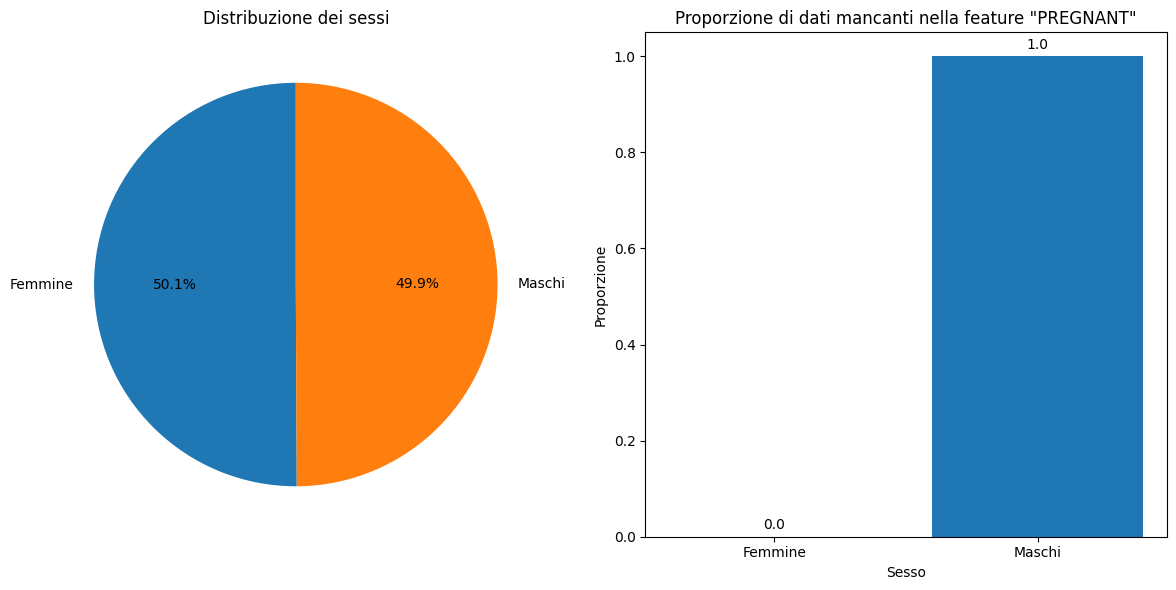

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Grafico a torta per la distribuzione dei sessi
data['SEX'].value_counts().plot(kind='pie', labels=['Femmine', 'Maschi'], autopct='%1.1f%%', startangle=90, ax=axs[0])
axs[0].set_title('Distribuzione dei sessi')
axs[0].set_ylabel('')

# Grafico a torta per la distribuzione dei pazienti vivi e morti
total_female = len(data[data['SEX'] == 1])
total_male = len(data[data['SEX'] == 2])

missing_female = len(data[(data['SEX'] == 1) & data['PREGNANT'].isin([97, 99])])
missing_male = len(data[(data['SEX'] == 2) & data['PREGNANT'].isin([97, 99])])

missing_female_prop = missing_female / total_female
missing_male_prop = missing_male / total_male

bars = axs[1].bar(['Femmine', 'Maschi'], [missing_female_prop, missing_male_prop])

# Aggiungo i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

axs[1].set_xlabel('Sesso')
axs[1].set_ylabel('Proporzione')
axs[1].set_title('Proporzione di dati mancanti nella feature "PREGNANT"')

plt.tight_layout()
plt.show()


Come possiamo vedere dal primo grafico, il dataset è bilanciato sui sessi con valori che si avvicinano molto al 50%. Il secondo grafico invece mostra il numero di valori assenti nella feature PREGNANT per ogni sesso, da questo possiamo notare che pressochè tutti i valori assenti riguardano maschi, e che quindi possiamo considerarli come dei "no" poichè i maschi non possono rimanere incinta, questa analisi verrà trattata meglio nella sezione successiva.

# Parte 3 - Preparazione dei Dati
In questa parte andrò a modificare i dati all'interno del dataframe, eliminando dati superflui o incompleti e ad ottimizzare l'uso della memoria.

Siccome le colonne INTUBED e ICU hanno per la maggior parte dei record valori assenti, e non sostituibili con qualche tecnica, vengono eliminate dal dataframe

In [34]:
print(data.INTUBED.value_counts())
print(data.ICU.value_counts())
data.drop(columns=["INTUBED","ICU"], inplace=True)

INTUBED
97    848544
2     159050
1      33656
99      7325
Name: count, dtype: int64
ICU
97    848544
2     175685
1      16858
99      7488
Name: count, dtype: int64


Della feature DATE_DIED, non ci importa la data di decesso o meno della persona, quindi possiamo convertirlo in un binario 1=vivo, 2=morto, sostituendo la colonna DATE_DIED con ALIVE

In [35]:
data["ALIVE"] = [0 if date=="9999-99-99" else 1 for date in data.DATE_DIED]
data.drop(columns=["DATE_DIED"], inplace=True)

Riguardo alla feature PREGNANT, come evidenziato nella sezione precedente, numerosi valori sono identificati come assenti, e questi appartengono principalmente a maschi, per questo motivo possiamo immetergli un valore PREGNANT uguale a 2 (False), mentre i pochi valori assenti rimanenti nei record con sesso femminile possiamo eliminarli siccome non sono un numero importante:

In [36]:
male_pregnant = data.loc[data.SEX == 2, 'PREGNANT'].value_counts()
female_pregnant = data.loc[data.SEX == 1, 'PREGNANT'].value_counts()
print(f"Male pregnants:\n{male_pregnant}\n")
print(f"Female pregnants:\n{female_pregnant}\n")

# Elimino i pochi record con sesso femminile senza informazioni sulla gravidanza
data = data[~((data.SEX == 1) & (data.PREGNANT != 1) & (data.PREGNANT != 2))]

# Converto tutti i record con sesso maschile in 2 (non incinta)
data = data.replace({'PREGNANT': {97: 2, 98: 2, 99: 2}})


Male pregnants:
PREGNANT
97    523511
Name: count, dtype: int64

Female pregnants:
PREGNANT
2     513179
1       8131
98      3754
Name: count, dtype: int64



Siccome la nostra analisi si basa sul capire quanto è critica la situazione di un paziente possiamo raggruppare le varie CLASSIFICATION_FINAL in due categorie, che andranno a rappresentare se il paziente ha contratto o meno il COVID:

In [37]:
data.CLASIFFICATION_FINAL = data.CLASIFFICATION_FINAL.replace([1,2,3], 1)
data.CLASIFFICATION_FINAL = data.CLASIFFICATION_FINAL.replace([4,5,6,7], 2)

Come mostato nel terzo grafico della precedente sezione, il numero di pazienti vivi è pari al 92.7%, numero nettamente superiore a quello dei pazienti morti, questo porterebbe un bias all'interno del modello, per evitare ciò decido di eliminare un gran numero di record riguardante i vivi in modo da portare il bilancio finale a 50/50, questo posso permettermelo siccome il dataset è molto grosso e riesco a mantenere comunque un numero sufficente di record.

In [38]:
alive = data[data['ALIVE'] == 0]
dead = data[data['ALIVE'] == 1]
num_dead = len(dead)

# Seleziono randomicamente un numero di pazienti vivi quanto quelli morti e li concateno con i record di pazienti morti
alive = alive.sample(n=num_dead)
data = pd.concat([alive, dead])

# Mischio i dati per evitare pattern
data = data.sample(frac=1).reset_index(drop=True)

In [39]:
data.shape

(153750, 19)

Siccome esistono ancora alcuni record con valori assenti e sono una quantità minima, eliminiamo i record contenenti valori tra 97 e 99. Non andiamo ad eseguire operazioni per provare a sostituire i valori assenti, poiche sono dati non riproducibili statisticamente e rischierebbe di peggiorare le prestazioni del modello finale.

In [40]:
# Creiamo una copia del dataframe senza la colonna 'AGE'
data_without_age = data.drop('AGE', axis=1)

print(f"Numero di record con feature tra 97 e 99 (esclusa 'AGE'): {data_without_age.apply(lambda col: col.isin([97, 98, 99]).sum()).sum()}")

# Rimuoviamo le righe che contengono i numeri 97, 98, 99 in qualsiasi colonna tranne 'AGE'
mask = data_without_age.isin([97, 98, 99]).any(axis=1)
data = data[~mask]

print("Shape finale del dataset:", data.shape)


Numero di record con feature tra 97 e 99: 11529
Shape finale del dataset: (149748, 19)


Andiamo ora invece ad analizzare i valori dei dati, in modo da capire se possiamo risparmiare memoria cambiando il tipo di dato a qualche feature.

In [41]:
for i in data.columns:
    print(i,": ",len(data[i].unique()))

USMER :  2
MEDICAL_UNIT :  13
SEX :  2
PATIENT_TYPE :  2
PNEUMONIA :  2
AGE :  106
PREGNANT :  2
DIABETES :  2
COPD :  2
ASTHMA :  2
INMSUPR :  2
HIPERTENSION :  2
OTHER_DISEASE :  2
CARDIOVASCULAR :  2
OBESITY :  2
RENAL_CHRONIC :  2
TOBACCO :  2
CLASIFFICATION_FINAL :  2
ALIVE :  2


Contando il numero di dati diversi all'interno delle varie features, possiamo notare che, esclusa AGE, tutte le feature hanno un numero molto contenuto di valori, per questo motivo possiamo raggrupparli attraverso la tipologia di dato category.

In [42]:
data['USMER'] = data['USMER'].astype('category')
data['MEDICAL_UNIT'] = data['MEDICAL_UNIT'].astype('category')
data['SEX'] = data['SEX'].astype('category')
data['PATIENT_TYPE'] = data['PATIENT_TYPE'].astype('category')
data['PNEUMONIA'] = data['PNEUMONIA'].astype('category')
data['PREGNANT'] = data['PREGNANT'].astype('category')
data['DIABETES'] = data['DIABETES'].astype('category')
data['COPD'] = data['COPD'].astype('category')
data['ASTHMA'] = data['ASTHMA'].astype('category')
data['INMSUPR'] = data['INMSUPR'].astype('category')
data['HIPERTENSION'] = data['HIPERTENSION'].astype('category')
data['OTHER_DISEASE'] = data['OTHER_DISEASE'].astype('category')
data['CARDIOVASCULAR'] = data['CARDIOVASCULAR'].astype('category')
data['OBESITY'] = data['OBESITY'].astype('category')
data['RENAL_CHRONIC'] = data['RENAL_CHRONIC'].astype('category')
data['TOBACCO'] = data['TOBACCO'].astype('category')
data['CLASIFFICATION_FINAL'] = data['CLASIFFICATION_FINAL'].astype('category')
data['ALIVE'] = data['ALIVE'].astype('category')

In [43]:
final_size = data.memory_usage(deep=True).sum()/1024**2

saved_memory = initial_size - final_size
saved_memory_percentage = (saved_memory / initial_size) * 100

print(f"Quantità di memoria risparmiata: {saved_memory:.2f} MB ({saved_memory_percentage:.2f}%)")

Quantità di memoria risparmiata: 214.14 MB (97.78%)


Infine attraverso una matrice delle correlazioni, possiamo vedere alcune correlazioni tra le variabili del dataframe:

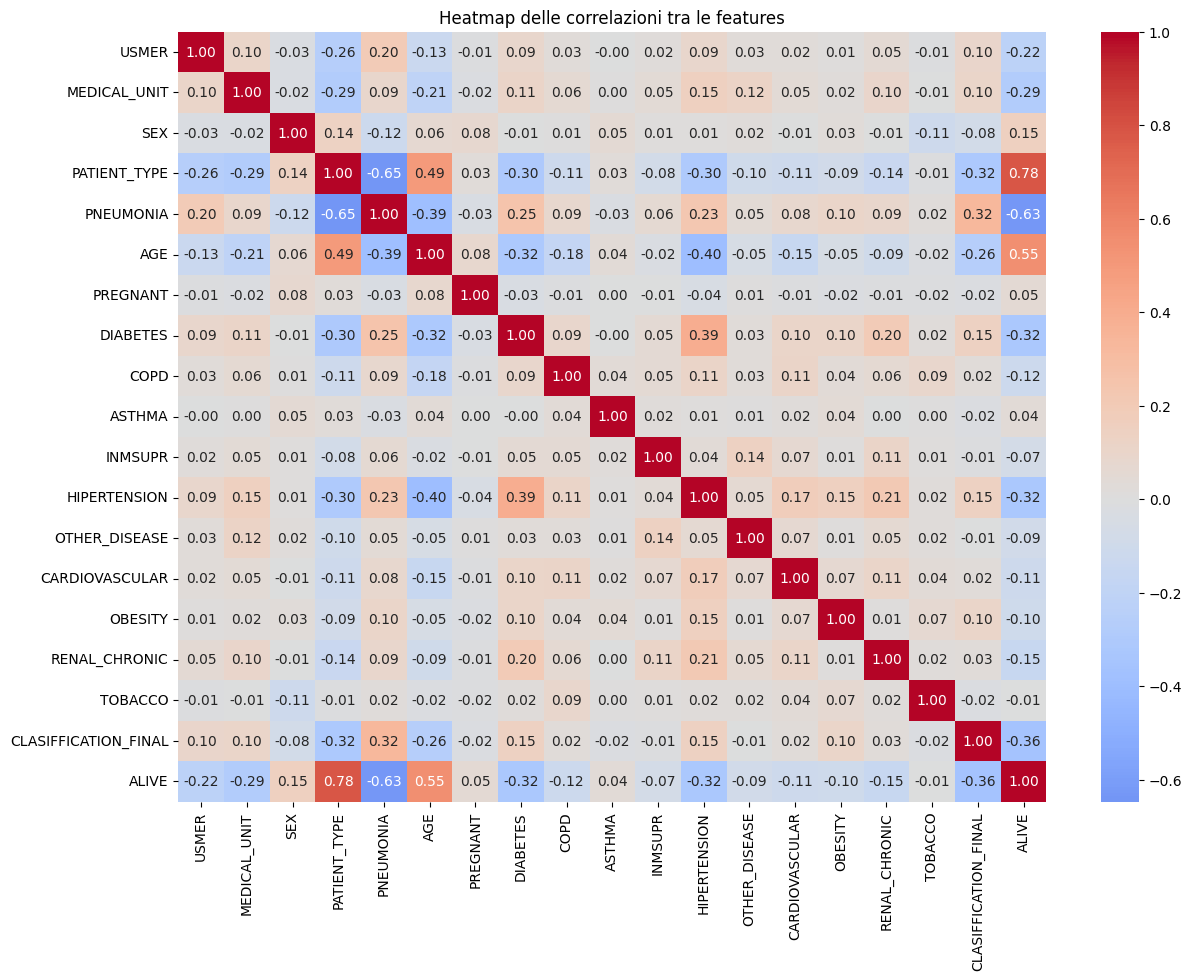

In [45]:
# Heatmap delle correlazioni tra le features
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Heatmap delle correlazioni tra le features')
plt.show()

In particolare riguardo ad ALIVE notiamo che:
- AGE ha un'importante influenza sullo stato ALIVE (come si poteva notare anche dal grafico della prima sezione)
- PATIENT_TYPE ha la più forte correlazione con ALIVE, ad indicare che pazienti trattenuti in ospedale hanno maggior probabilità di morire che quelli mandati casa
- PNEUMONIA al contrario ha una forte correlazione inversa, indicando che chi ha infiammazioni alle vie respiratoie è molto più probabile che muoia
- CLASSIFICATION_FINAL che ricordo indichi se sia o meno malato di covid, ha una notevole correlazione inversa con ALIVE, ad indicare che chi è già malato di COVID-19 è meno probabile che riesca a sopravvivere

# 4 - Addestramento e Validazione dei Modelli

Gestisco le variabili categorice attraverso un one-hot encode, abilitando il parametro drop_first in modo da evitare multicollinearità.

In [46]:
df = data.copy()

# Eseguo il one hot encoding per le colonne categoriche
columns_to_encode = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 
                     'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                     'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL']

df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

x = df.drop(columns="ALIVE")
y = df["ALIVE"]

df.head()

,AGE,ALIVE,USMER_2,MEDICAL_UNIT_2,MEDICAL_UNIT_3,MEDICAL_UNIT_4,MEDICAL_UNIT_5,MEDICAL_UNIT_6,MEDICAL_UNIT_7,MEDICAL_UNIT_8,...,COPD_2,ASTHMA_2,INMSUPR_2,HIPERTENSION_2,OTHER_DISEASE_2,CARDIOVASCULAR_2,OBESITY_2,RENAL_CHRONIC_2,TOBACCO_2,CLASIFFICATION_FINAL_2
0,25,0,True,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,36,0,True,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,25,0,False,False,False,True,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,40,0,False,False,False,True,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
4,56,0,False,False,False,False,False,True,False,False,...,True,True,True,False,True,True,True,True,True,True


In [68]:
# Creo una funzione template per testare diversi modelli attraverso kfold cross validation
def kFoldValidation(model, parameters, x, y):
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)

    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model)
    ])

    # Setto i parametri del modello
    pipeline_parameters = {f'model__{key}': parameters[key] for key in parameters}

    # Eseguo la grid search
    grid_search = GridSearchCV(pipeline, pipeline_parameters, cv=kfold, verbose=3)
    grid_search.fit(x, y)
    
    # Calcolo precision, recall e l'F1 score
    precision = make_scorer(precision_score)
    recall = make_scorer(recall_score)
    f1 = make_scorer(f1_score)
    
    precision_result = precision(grid_search.best_estimator_, x, y)
    recall_result = recall(grid_search.best_estimator_, x, y)
    f1_result = f1(grid_search.best_estimator_, x, y)

    print(f"{model.__class__.__name__}: Best parameters: {grid_search.best_params_}, Accuracy: {grid_search.best_score_}, Precision: {precision_result}, Recall: {recall_result}, F1 score: {f1_result}")
    
    return grid_search.best_estimator_, grid_search.best_score_, precision_result, recall_result, f1_result


In [70]:
# Logistic Regression
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.1, 1, 10, 1000]}
lr, lr_best_acc, lr_precision, lr_recall, lr_f1 = kFoldValidation(lr, lr_params, x, y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END ...................model__C=0.001;, score=0.906 total time=   0.2s
[CV 2/10] END ...................model__C=0.001;, score=0.908 total time=   0.2s
[CV 3/10] END ...................model__C=0.001;, score=0.906 total time=   0.2s
[CV 4/10] END ...................model__C=0.001;, score=0.913 total time=   0.2s
[CV 5/10] END ...................model__C=0.001;, score=0.911 total time=   0.2s
[CV 6/10] END ...................model__C=0.001;, score=0.911 total time=   0.2s
[CV 7/10] END ...................model__C=0.001;, score=0.906 total time=   0.2s
[CV 8/10] END ...................model__C=0.001;, score=0.906 total time=   0.2s
[CV 9/10] END ...................model__C=0.001;, score=0.910 total time=   0.2s
[CV 10/10] END ..................model__C=0.001;, score=0.909 total time=   0.2s
[CV 1/10] END .....................model__C=0.1;, score=0.907 total time=   0.2s
[CV 2/10] END .....................model__C=0.1;

In [71]:
# Random Forest
rf = RandomForestClassifier()
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 15]}
rf, rf_best_acc, rf_precision, rf_recall, rf_f1 = kFoldValidation(rf, rf_params, x, y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END model__max_depth=None, model__n_estimators=100;, score=0.899 total time=  13.2s
[CV 2/10] END model__max_depth=None, model__n_estimators=100;, score=0.899 total time=  13.7s
[CV 3/10] END model__max_depth=None, model__n_estimators=100;, score=0.899 total time=  14.2s
[CV 4/10] END model__max_depth=None, model__n_estimators=100;, score=0.905 total time=  13.4s
[CV 5/10] END model__max_depth=None, model__n_estimators=100;, score=0.899 total time=  13.6s
[CV 6/10] END model__max_depth=None, model__n_estimators=100;, score=0.903 total time=  13.8s
[CV 7/10] END model__max_depth=None, model__n_estimators=100;, score=0.899 total time=  13.4s
[CV 8/10] END model__max_depth=None, model__n_estimators=100;, score=0.898 total time=  13.3s
[CV 9/10] END model__max_depth=None, model__n_estimators=100;, score=0.898 total time=  12.9s
[CV 10/10] END model__max_depth=None, model__n_estimators=100;, score=0.902 total time=  13.4

In [72]:
# XGBoost
xgb = XGBClassifier()
xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3]}
xgb, xgb_best_acc, xgb_precision, xgb_recall, xgb_f1 = kFoldValidation(xgb, xgb_params, x, y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.914 total time=   0.8s
[CV 2/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.913 total time=   0.8s
[CV 3/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.915 total time=   0.7s
[CV 4/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.917 total time=   0.7s
[CV 5/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.916 total time=   0.8s
[CV 6/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.917 total time=   0.8s
[CV 7/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.913 total time=   0.7s
[CV 8/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.912 total time=   0.7s
[CV 9/10] END model__learning_rate=0.01, model__n_estimators=100;, score=0.915 total time=   0.7s
[CV 10/10] END model__learning_rate=0.01, model__n_estima

In [73]:
# Decision Tree
dt = DecisionTreeClassifier()
dt_params = {'max_depth': [None, 5, 15], 'min_samples_split': [2, 5, 10]}
dt, dt_best_acc, dt_precision, dt_recall, dt_f1 = kFoldValidation(dt, dt_params, x, y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END model__max_depth=None, model__min_samples_split=2;, score=0.879 total time=   0.6s
[CV 2/10] END model__max_depth=None, model__min_samples_split=2;, score=0.880 total time=   0.6s
[CV 3/10] END model__max_depth=None, model__min_samples_split=2;, score=0.878 total time=   0.6s
[CV 4/10] END model__max_depth=None, model__min_samples_split=2;, score=0.884 total time=   0.6s
[CV 5/10] END model__max_depth=None, model__min_samples_split=2;, score=0.878 total time=   0.6s
[CV 6/10] END model__max_depth=None, model__min_samples_split=2;, score=0.883 total time=   0.7s
[CV 7/10] END model__max_depth=None, model__min_samples_split=2;, score=0.878 total time=   0.9s
[CV 8/10] END model__max_depth=None, model__min_samples_split=2;, score=0.879 total time=   0.8s
[CV 9/10] END model__max_depth=None, model__min_samples_split=2;, score=0.880 total time=   0.8s
[CV 10/10] END model__max_depth=None, model__min_samples_split=2;,

In [74]:
# Perceptron
perc = Perceptron()
perc_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
perc, perc_best_acc, perc_precision, perc_recall, perc_f1 = kFoldValidation(perc, perc_params, x, y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10] END ..............model__alpha=0.0001;, score=0.863 total time=   0.4s
[CV 2/10] END ..............model__alpha=0.0001;, score=0.852 total time=   0.3s
[CV 3/10] END ..............model__alpha=0.0001;, score=0.870 total time=   0.3s
[CV 4/10] END ..............model__alpha=0.0001;, score=0.831 total time=   0.3s
[CV 5/10] END ..............model__alpha=0.0001;, score=0.880 total time=   0.4s
[CV 6/10] END ..............model__alpha=0.0001;, score=0.889 total time=   0.3s
[CV 7/10] END ..............model__alpha=0.0001;, score=0.881 total time=   0.3s
[CV 8/10] END ..............model__alpha=0.0001;, score=0.872 total time=   0.3s
[CV 9/10] END ..............model__alpha=0.0001;, score=0.856 total time=   0.4s
[CV 10/10] END .............model__alpha=0.0001;, score=0.845 total time=   0.3s
[CV 1/10] END ...............model__alpha=0.001;, score=0.863 total time=   0.4s
[CV 2/10] END ...............model__alpha=0.001;

Epoch 1/50


c:\Users\giaco\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3744/3744 ━━━━━━━━━━━━━━━━━━━━ 4s 798us/step - accuracy: 0.8974 - loss: 0.2757
Epoch 2/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 752us/step - accuracy: 0.9147 - loss: 0.2356
Epoch 3/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 778us/step - accuracy: 0.9161 - loss: 0.2334
Epoch 4/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 808us/step - accuracy: 0.9164 - loss: 0.2325
Epoch 5/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 788us/step - accuracy: 0.9165 - loss: 0.2318
Epoch 6/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 796us/step - accuracy: 0.9171 - loss: 0.2306
Epoch 7/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 787us/step - accuracy: 0.9171 - loss: 0.2298
Epoch 8/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 732us/step - accuracy: 0.9164 - loss: 0.2319
Epoch 9/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 761us/step - accuracy: 0.9176 - loss: 0.2305
Epoch 10/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 725us/step - accuracy: 0.9179 - loss: 0.2282
Epoch 11/50
3744/3744 ━━━━━━━━━━━━━━━━━━━━ 3s 736us/step - accuracy: 0.9176 - loss: 0.2297
Epoch 12/50
3744/37

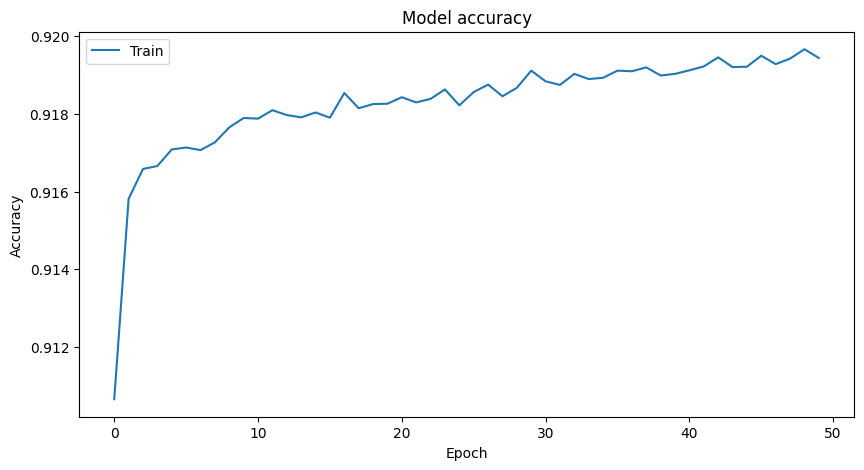

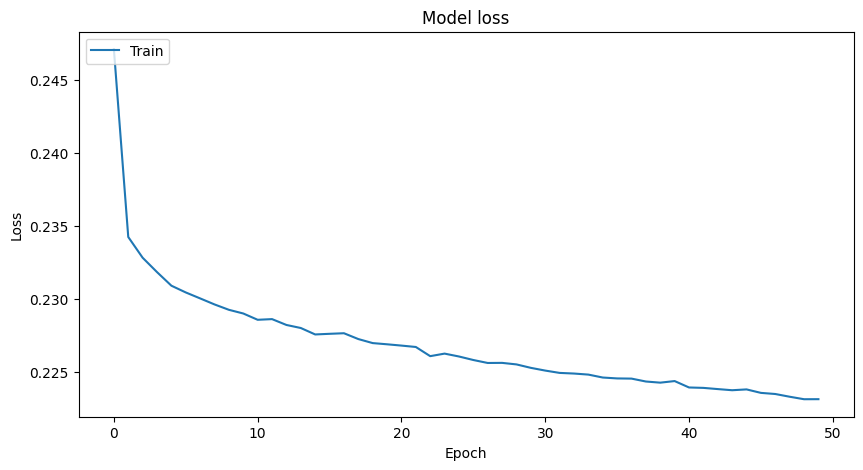

In [75]:
# Preparazione dell'input
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

train_y_categorical = to_categorical(train_y)
test_y_categorical = to_categorical(test_y)

# Definisco il modello
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=train_x.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(train_y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train del modello
history = model.fit(train_x, train_y_categorical, epochs=50, batch_size=32, verbose=1)

# Calcolo delle varie metriche
loss, nn_best_acc = model.evaluate(test_x, test_y_categorical)

y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)

nn_precision = precision_score(test_y, y_pred_classes, average='binary')
nn_recall = recall_score(test_y, y_pred_classes, average='binary')
nn_f1 = f1_score(test_y, y_pred_classes, average='binary')

# Grafico dell'accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoca')
plt.legend(['Train'], loc='upper left')
plt.show()

# Grafioc della loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Train'], loc='upper left')
plt.show()

# 5 - Analisi dei Risultati

Elenco nella tabella di seguito i vari risultati dei modelli:

In [76]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Decision Tree', 'Perceptron', 'Neural Network']
accuracies = [lr_best_acc, rf_best_acc, xgb_best_acc, dt_best_acc, perc_best_acc, nn_best_acc]

precisions = [lr_precision, rf_precision, xgb_precision, dt_precision, perc_precision, nn_precision]
recalls = [lr_recall, rf_recall, xgb_recall, dt_recall, perc_recall, nn_recall]
f1_scores = [lr_f1, rf_f1, xgb_f1, dt_f1, perc_f1, nn_f1]

df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

print(df)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.908480   0.895196  0.924445  0.909585
1        Random Forest  0.915658   0.897892  0.966226  0.930807
2              XGBoost  0.916339   0.889143  0.956167  0.921437
3        Decision Tree  0.912533   0.879993  0.955711  0.916290
4           Perceptron  0.863804   0.778698  0.783502  0.781092
5       Neural Network  0.913055   0.881409  0.953827  0.916189


Dato il mio caso in esame, siccome voglio evitare sia dei falsi negativi perché è importante che le persone con priorità ricevano un trattamento adeguato in tempo (e per questo sceglierei la metrica recall), ma voglio anche evitare falsi positivi, per minimizzare le risorse sprecate (e per questo sceglierei la metrica relativa alla precisione). Una buona via di mezzo la si ottiene considerando il punteggio F1.

In particolare, facendo riferimento alla tabella sopra riportata, siccome il migliore modello è Random Forest, possiamo estrarre i valori delle feature più importanti e mostrarli in un grafico:

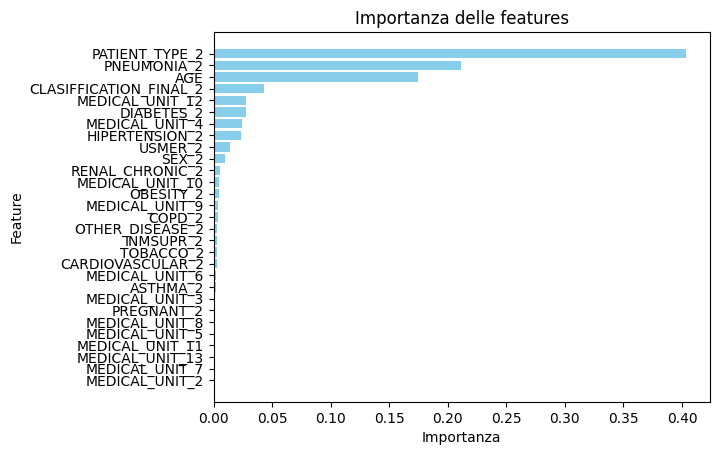

In [78]:
feature_importances = rf[1].feature_importances_

features_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importances
})

# Ordino per importanza
features_df = features_df.sort_values(by='Importance', ascending=False)

plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.title('Importanza delle features')
plt.gca().invert_yaxis()
plt.show()

Dal grafico possiamo vedere come le tre feature che più influenzano la salute futura del paziente sono: PATIENT_TYPE_2 (se è ricoverato in ospedale), PNEUMONIA (se il paziente ha infiammazioni alle vie respiratoie) e AGE (l'età del paziente).